# Обработка эксперимента Сбермаркета

На текущем варианте лендинга пользователь сначала выбирает ритейлера, переходит в каталог, ищет нужные ему товары и только потом может узнать, что по его адресу выбранного магазина может не оказаться. Необходимо проверить гипотезу, что выбор адреса до этапа выбора магазина поможет избежать “кривых” сценариев без повышения отказов с самого лендинга.

**Необходимо:**
- Проанализировать дизайн эксперимента. Какие ошибки были допущены? Как можно его улучшить?
- Проанализировать данные эксперимента. Какой из вариантов нужно пускать в бой по итогу A/B теста и почему?  
- Провести неофициальное расследование и составьте максимально подробный список таких особенностей в приведенных данных. 


## Техническое вступление

In [ ]:
import pandas as pd
import numpy as np
from scipy import stats 

import matplotlib.pyplot as plt
import plotly.express as px
from plotly import graph_objects as go
from plotly.subplots import make_subplots

from collections import namedtuple, defaultdict
import math

pd.set_option('display.max_colwidth', -1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: FutureWarning:

Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.



In [ ]:
# Пути пользователей в тестовой группе 
!gdown --id 1s0VRCXqBQZX8maokByEU7cgzr31e3VpY

# Пути пользователей в контрольной группе 
!gdown --id 12zeoZX9_bwWvJ48dnYlgMfb3Tq7_iGU6

# Данные
!gdown --id 1LqgDKXBVk1Whx_Ro75vuiyJkLlKGkbtb

Downloading...
From: https://drive.google.com/uc?id=1s0VRCXqBQZX8maokByEU7cgzr31e3VpY
To: /content/sequence_actions_users_test_gr.txt
100% 112k/112k [00:00<00:00, 43.7MB/s]
Downloading...
From: https://drive.google.com/uc?id=12zeoZX9_bwWvJ48dnYlgMfb3Tq7_iGU6
To: /content/sequence_actions_users_default_gr.txt
100% 326k/326k [00:00<00:00, 47.1MB/s]
Downloading...
From: https://drive.google.com/uc?id=1LqgDKXBVk1Whx_Ro75vuiyJkLlKGkbtb
To: /content/All_files.zip
74.0MB [00:01, 44.3MB/s]


In [ ]:
!unzip All_files.zip

Archive:  All_files.zip
  inflating: Career Factory/Shop Selection Started.csv  
  inflating: Career Factory/Address Not In Delivery Zone.csv  
  inflating: Career Factory/Address Change Initiated.csv  
  inflating: Career Factory/Order Completed.csv  
  inflating: Career Factory/Shop Selected.csv  
  inflating: Career Factory/Landing Viewed.csv  
  inflating: Career Factory/AB Test Hit.csv  
  inflating: Career Factory/Main Page Viewed.csv  
  inflating: Career Factory/Add To Cart Clicked.csv  
  inflating: Career Factory/Product Added.csv  


## Рассмотрение деления на A/B группы

In [ ]:
AB_df['hit_at'].max()

Timestamp('2020-12-10 23:59:57.308000')

In [ ]:
AB_df['hit_at'].min()

Timestamp('2020-11-26 00:00:10.318000')

In [ ]:
AB_df = pd.read_csv('/content/Career Factory/AB Test Hit.csv')
AB_df['hit_at'] = pd.to_datetime(AB_df['hit_at'].str[:-4], format="%Y-%m-%d %H:%M:%S")
AB_df.info()
AB_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 502784 entries, 0 to 502783
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   hit_at        502784 non-null  datetime64[ns]
 1   anonymous_id  502784 non-null  object        
 2   group         502784 non-null  object        
 3   device_type   502784 non-null  object        
 4   browser       502784 non-null  object        
 5   os            502783 non-null  object        
dtypes: datetime64[ns](1), object(5)
memory usage: 23.0+ MB


,hit_at,anonymous_id,group,device_type,browser,os
0,2020-11-30 04:21:38.616,3e05a2dc-3922-4caf-b837-08fcb337c82e,default,desktop,IE,Windows
1,2020-12-01 20:24:04.363,7f00b6ca-7938-4866-a323-c520838f5ef9,default,desktop,IE,Windows
2,2020-11-28 20:16:52.901,91e9900e-2cc6-4362-92b4-9e6712a6918e,address_first,desktop,IE,Windows
3,2020-11-29 13:29:40.557,616dd5e8-dee2-47aa-9d80-0dfadcf1922f,default,desktop,IE,Windows
4,2020-11-27 14:56:29.471,64734da4-d9f3-4d53-b401-4d0819a6e5fb,default,desktop,IE,Windows


In [ ]:
print(f'Полных дубликатов в AB_df = {AB_df.duplicated().sum()}.')

print('Дубликатов в AB_df, отличающихся датой = {}.'.
      format(AB_df.loc[:, 'anonymous_id':'os'].duplicated().sum()))

Полных дубликатов в AB_df = 0.
Дубликатов в AB_df, отличающихся датой = 13140.


In [ ]:
display(AB_df[AB_df['os'].isnull()])
AB_df = AB_df.drop(AB_df[AB_df['os'].isnull()].index)

,hit_at,anonymous_id,group,device_type,browser,os
353476,2020-11-26 08:04:14.164,43c2bbe6-ba74-4b76-9597-421d3175ad30,default,desktop,Firefox,NaN


Всего лишь 1 пропуск в одном столбце, но дополнительно стоит рассмотреть в связи с чем он мог появиться.

13140 дубликатов, которые пристальнее рассмотрим  ниже.

### Функции для анализа

In [ ]:
analyze_columns = ['device_type', 'browser', 'os']

def define_count_users_not_unique(df):
  """
  Определяет количество пользователей, у которых в наборе столбцов
  analyze_columns более одного уникального значения.
  
  df - рассматриваемый датафрейм пользователей
  """
  
  for column_name in analyze_columns: 
    print('У {} пользователей в столбце {} более одного уникального значения.'.
        format(len(df.groupby('anonymous_id')[column_name].nunique().
                   reset_index().query(f'{column_name} > 1')), column_name))

In [ ]:
def skew_check(df1, df2, check_column, deviation_limit, suffixes_):
  """
  Проверяет отсутствие перекоса в двух датафреймах в заданном столбце.

  df1 - первый датафрейм для сравнения 
  df2 - второй датафрейм для сравнения 
  check_column - проверяемый столбец
  deviation_limit - отклонение в двух группах, считаемое допустимым 
  suffixes_ - суффиксы к столбцу сравнения
  """
  
  # Формирования относительного разделения по значениям столбца
  df1_rel = (round(df1[check_column].value_counts() / len(df1), 2)).reset_index()
  df2_rel = (round(df2[check_column].value_counts() / len(df2), 2)).reset_index()
  
  df_aggregate = df1_rel.merge(df2_rel, how='outer', on='index',
                                  suffixes=(suffixes_[0], suffixes_[1]))
  
  # Сравнение разницы частей в двух группах 
  df_aggregate['compare_parts'] = abs(df_aggregate[f'{check_column}{suffixes_[0]}']
                                  - df_aggregate[f'{check_column}{suffixes_[1]}'])
  
  return df_aggregate.query('compare_parts > @deviation_limit')\
  [['index', f'{check_column}{suffixes_[0]}', f'{check_column}{suffixes_[1]}']]

In [ ]:
def get_sequence_actions(arr_actions):
    """
    Получение последовательности событий для пользователя

    arr_actions - упорядоченный по времени массив всех действий пользователя 
    """
    list_sequence = list()
    for element in arr_actions:
        if element not in list_sequence:
            list_sequence.append(element)
        
        if len(list_sequence) == 9:
            break;
            
    return str(list_sequence)[1:-1]

In [ ]:
def get_top_sequence(df):
    """
    Получение словаря последовательностей событий и частоты их встречаемости

    df - рассматриваемый датафрейм
    """
  
    dict_sequences = defaultdict(int)
    
    for id_user in df['anonymous_id'].unique():
        result_functions = get_sequence_actions(df.query('anonymous_id == @id_user')
                                  .sort_values('timestamp')['type_action'].values)
        
        dict_sequences[result_functions] += 1

    return dict_sequences

Функции путей пользователя находят лишь последовательность первых, уникальных действий.

### Пользователи попавшие в AB_df более одного раза

In [ ]:
ids_more1_once = AB_df.groupby('anonymous_id')['hit_at'].count().reset_index().\
            query('hit_at > 1')['anonymous_id'].values

AB_more1_once_df = AB_df.query('anonymous_id in @ids_more1_once').copy()
define_count_users_not_unique(AB_more1_once_df)

У 66 пользователей в столбце device_type более одного уникального значения.
У 57 пользователей в столбце browser более одного уникального значения.
У 54 пользователей в столбце os более одного уникального значения.


In [ ]:
print('Пользователей, которые попали в таблицу разделения на группы более 1 раза =',
      AB_more1_once_df['anonymous_id'].nunique())

print('Пользователей, всего =', AB_df['anonymous_id'].nunique())

Пользователей, которые попали в таблицу разделения на группы более 1 раза = 11120
Пользователей, всего = 489018


In [ ]:
# Эквивалент ячейки ниже, просто работает 4 минуты
# info_by_id_all_df = AB_df.groupby('anonymous_id')[['os', 'device_type', 'browser']].max().reset_index()

Такая группировка допустима, по причине малого числа пользователей с различными устройствами, браузерами, ОС.

In [ ]:
!gdown --id 1mFdJcC1vLlDzbkpprctI4PuMTCZXurCY
info_by_id_all_df = pd.read_csv('/content/statistics_by_id.csv')

Downloading...
From: https://drive.google.com/uc?id=1mFdJcC1vLlDzbkpprctI4PuMTCZXurCY
To: /content/statistics_by_id.csv
29.4MB [00:00, 80.4MB/s]


In [ ]:
for column_name in analyze_columns:
  print(f'В столбце - {column_name}, отличаются  следующие относительные значения:\n', 
        skew_check(AB_more1_once_df, 
                  info_by_id_all_df, column_name, 0.1, ['_duplicate', '_all']), '\n')

В столбце - device_type, отличаются  следующие относительные значения:
 Empty DataFrame
Columns: [index, device_type_duplicate, device_type_all]
Index: [] 

В столбце - browser, отличаются  следующие относительные значения:
 Empty DataFrame
Columns: [index, browser_duplicate, browser_all]
Index: [] 

В столбце - os, отличаются  следующие относительные значения:
      index  os_duplicate  os_all
0  Windows  0.4           0.27   



Лишь 2.3% от всех пользователей в А, В тестировании попали в таблицу более одного раза, часть незначительная. Заметных отличий этих пользователей, относительно остальных не обнаружено, они пользовались одними и теми же устройствами, операционной системой, браузером.

Определим, есть ли особенности у пользователей, которые при этом были определены в две разные группы.

### Пользователи, попавшие в обе группы теста

In [ ]:
ids_default = set(AB_df.query('group == "default"')['anonymous_id'].values)
ids_address_first = set(AB_df.query('group == "address_first"')['anonymous_id'].values)
intersaction_ids = ids_address_first & ids_default
ids_address_first = ids_address_first - intersaction_ids
ids_default = ids_default - intersaction_ids
print('Количество пользователей, которые оказались в двух группах = {}'.format(len(intersaction_ids)))

Количество пользователей, которые оказались в двух группах = 528


Расследуем, чем характерны пользователи, попавшие в обе группы А/В теста.

In [ ]:
AB_intersection_df = AB_df.query('anonymous_id in @intersaction_ids')

# Некоторые пользователи в df_AB встречаются более 2 раз, поэтому столь нагроможденная конструкция 
user_times_to_A_B_gr = AB_intersection_df.groupby(['anonymous_id', 'group'])['hit_at'].\
min().reset_index().groupby('anonymous_id').agg({'hit_at': ['min', 'max']}).reset_index()

# Определение разности отнесения к различным группам
user_times_to_A_B_gr.columns = user_times_to_A_B_gr.columns.droplevel()
user_times_to_A_B_gr = user_times_to_A_B_gr.rename({(''): 'anonymous_id'}, axis=1)
user_times_to_A_B_gr['sub'] = user_times_to_A_B_gr['max'] - user_times_to_A_B_gr['min']

# Определение числа пользователей, по интервалам времени отнесения к разным группам
user_times_to_A_B_gr['intervals_time'] = pd.cut(user_times_to_A_B_gr['sub'],
    list(map(pd.Timedelta, ['-1 days 00:00:00', '0 days 00:01:00', '0 days 01:00:00', 
                        '1 days 00:00:00', '5 days 00:00:00', '15 days 00:00:00'])))
user_times_to_A_B_gr.groupby('intervals_time')['anonymous_id'].nunique()

intervals_time
(-1 days +00:00:00, 0 days 00:01:00]    426
(0 days 00:01:00, 0 days 01:00:00]      42 
(0 days 01:00:00, 1 days 00:00:00]      26 
(1 days 00:00:00, 5 days 00:00:00]      21 
(5 days 00:00:00, 15 days 00:00:00]     13 
Name: anonymous_id, dtype: int64

80% пользователей, которые попали в обе группы были отнесены в них с разностью менее 1 минуты.

In [ ]:
define_count_users_not_unique(AB_intersection_df)
info_by_id_intersection_df = AB_intersection_df.groupby('anonymous_id') \
  [analyze_columns].max().reset_index()

У 0 пользователей в столбце device_type более одного уникального значения.
У 0 пользователей в столбце browser более одного уникального значения.
У 0 пользователей в столбце os более одного уникального значения.


Значит все пользователи принадлежащие различным группам были отнесены с одного типа устройств, браузера, ОС, определим с каких именно.

In [ ]:
for column_name in analyze_columns:
  print(f'В столбце - {column_name}, отличаются  следующие относительные значения:\n', 
        skew_check(info_by_id_intersection_df, 
                   info_by_id_all_df, column_name, 0.1, ['_intersection', '_all']), '\n')

В столбце - device_type, отличаются  следующие относительные значения:
      index  device_type_intersection  device_type_all
0  mobile   0.80                      0.61           
1  desktop  0.18                      0.38            

В столбце - browser, отличаются  следующие относительные значения:
            index  browser_intersection  browser_all
5  Mobile Safari  0.03                  0.17        

В столбце - os, отличаются  следующие относительные значения:
      index  os_intersection  os_all
0  Android  0.76             0.39  
1  Windows  0.15             0.27  
2  iOS      0.06             0.23   



Некоторые соотношение встречаемости различных значений в столбцах для этих пользователей не характерны для общих соотношений.

In [ ]:
AB_df = AB_df.query('anonymous_id not in @intersaction_ids')
AB_df = AB_df.groupby(['anonymous_id', 'device_type', 'browser', 'os', 'group'])['hit_at'].\
        min().reset_index()

# Борьба с пользователями, которые попали несколько раз с разных источников
dropping_users = AB_df['anonymous_id'].value_counts().\
        sort_values().reset_index().query('anonymous_id == 2')['index'].values
AB_df = AB_df.query('anonymous_id not in @dropping_users')

### Вывод о делении
1. 2.3% пользователей попали в разделение на группы дважды и более раз, что говорит о некорректной работе способа разбиения.

2. Имеются существенные отличия в относительном числе значений в некоторых столбцах пользователей, отнесенных в разные группы, что может свидетельствовать о некорректном разбиении для некоторых ОС, устройств. Рекомендую обратить  внимание на метод присваивания группы A/B теста следующим пользователям:

  * c устройством mobile;
  * ОС Android;
  * кто обращался к сервису чаще раза в минуту.

3. Имелся единственный пропуск ОС во всём датасете, он не фатален, но стоит конкретнее изучить возможные причины появления.

В дальнейшем рассмотрении не будут участвовать пользователи, попавшие в обе группы тестирования.

## Пользовательские сценарии


In [ ]:
all_stages_df = pd.DataFrame([], columns=['anonymous_id', 'timestamp', 'type_action'])
count_users_test_gr, count_users_control_gr = [], []

stages_path_user = ['Landing Viewed', 'Main Page Viewed', 'Add To Cart Clicked',
                    'Address Change Initiated', 'Shop Selected', 
                    'Product Added', 'Shop Selection Started', 'Order Completed']

for stage in stages_path_user:
  tmp_df = pd.read_csv(f'/content/Career Factory/{stage}.csv')
  tmp_df['type_action'] = stage
  tmp_df['timestamp'] = pd.to_datetime(tmp_df['timestamp'].str[:-4], format="%Y-%m-%d %H:%M:%S")

  all_stages_df = pd.concat([all_stages_df, tmp_df])

  count_users_control_gr.append(tmp_df.query('anonymous_id in @ids_default')['anonymous_id'].nunique())
  count_users_test_gr.append(tmp_df.query('anonymous_id in @ids_address_first')['anonymous_id'].nunique())

### Особенность разделения на группы

In [ ]:
ids_AB = set(AB_df['anonymous_id'].unique())
ids_stages = set(all_stages_df['anonymous_id'].unique())
substraction_sets = ids_AB - ids_stages
print('{} - число пользователей, отнесённых к группе, '\
      'но не совершивших не единого действия'.format(len(substraction_sets)))

192231 - число пользователей, отнесённых к группе, но не совершивших не единого действия


In [ ]:
 for column_name in analyze_columns:
  print(f'В столбце - {column_name}, отличаются  следующие относительные значения:\n', 
        skew_check(info_by_id_all_df.query('anonymous_id in @ids_stages'),  
                   info_by_id_all_df, column_name, 0.1, ['_intersection', '_all']), '\n')

В столбце - device_type, отличаются  следующие относительные значения:
 Empty DataFrame
Columns: [index, device_type_intersection, device_type_all]
Index: [] 

В столбце - browser, отличаются  следующие относительные значения:
 Empty DataFrame
Columns: [index, browser_intersection, browser_all]
Index: [] 

В столбце - os, отличаются  следующие относительные значения:
 Empty DataFrame
Columns: [index, os_intersection, os_all]
Index: [] 



192231 пользователь был отнесен к группе, но не совершил за наблюдаемый промежуток времени не единого действия. Подозрительно. Но и для пользователей, совершивших хоть какие-то действия существенных различий в распределении категогрий не появилось. Исследуем, как распределено время первых контактов с сервисом и время отнесения к группе.

In [ ]:
first_action_user_df = all_stages_df.groupby('anonymous_id')['timestamp'].min().\
                  reset_index()

first_action_user_df = first_action_user_df.merge(AB_df, on='anonymous_id')
first_action_user_df['delta_time'] = first_action_user_df['hit_at'] -\
                                    first_action_user_df['timestamp']

In [ ]:
first_action_user_df['interval'] = pd.cut(first_action_user_df['delta_time'],  
      list(map(pd.Timedelta, ['-23 days 00:00:00', '-1 days 00:00:00', '-1 days +23:00:00', 
                            '-1 days +23:59:00', '0 days 00:00:00', '0 days 00:01:00',
                            '0 days 01:00:00', '1 days 00:00:00', '15 days 00:00:00'])))

for_plotly = first_action_user_df['interval'].value_counts().reset_index()
for_plotly['index'] = for_plotly['index'].astype('str')
for_plotly['index'] = for_plotly['index'].str.replace(':00,', ',').str.replace(':00]', ']')
for_seaborn = for_plotly[:2]
for_plotly = for_plotly[2:]

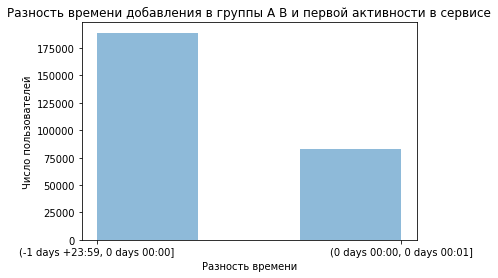

In [ ]:
plt.hist(for_seaborn['index'], weights=for_seaborn['interval'], bins = 3, alpha = 0.5, label='Wii')
plt.ylabel('Число пользователей')
plt.xlabel('Разность времени')
plt.title('Разность времени добавления в группы А В и первой активности в сервисе');

In [ ]:
fig = go.Figure(go.Bar(x=for_plotly['index'], y=for_plotly['interval']))

fig.update_layout(title="Гистограмма распределения разницы между первым действием и добавлением в группу",
                  xaxis_title="Разность времени",
                  yaxis_title="Число пользователей",
                  width=850,
                  height=500)
fig.update_traces(hoverinfo="all", 
      hovertemplate="Временной промежуток: %{x}<br> Число пользователей: %{y}")

fig.show();

Если разница между добавлением в группу A/B теста и первым действием меньше минуты, это кажется логичным, но когда разница более суток в ту или иную сторону это кажется странным, предметнее расмотрим такие сценарии.

### Пользовательские пути тестовой группы

In [ ]:
first_action_user_df['interval'] = first_action_user_df['interval'].astype('str')

In [ ]:
ids_B_gr_incorrect = first_action_user_df.query('interval == "(1 days 00:00:00,'\
          ' 15 days 00:00:00]" and group == "address_first"')['anonymous_id'].unique()
all_stages_B_gr_incorrect = all_stages_df.query('anonymous_id in @ids_B_gr_incorrect')
dict_path_B_gr_incorrect = get_top_sequence(all_stages_B_gr_incorrect)
sorted(dict_path_B_gr_incorrect.items(), key=lambda x: x[1], reverse= True)[:10]

[("'Main Page Viewed', 'Shop Selected', 'Add To Cart Clicked', 'Product Added', 'Landing Viewed'",
  20),
 ("'Main Page Viewed', 'Add To Cart Clicked', 'Product Added', 'Landing Viewed'",
  20),
 ("'Main Page Viewed', 'Add To Cart Clicked', 'Product Added', 'Shop Selected', 'Landing Viewed'",
  18),
 ("'Main Page Viewed', 'Add To Cart Clicked', 'Product Added', 'Landing Viewed', 'Shop Selected'",
  12),
 ("'Main Page Viewed', 'Shop Selected', 'Add To Cart Clicked', 'Product Added'",
  11),
 ("'Shop Selected', 'Main Page Viewed', 'Add To Cart Clicked', 'Product Added'",
  9),
 ("'Landing Viewed'", 8),
 ("'Main Page Viewed', 'Add To Cart Clicked', 'Product Added'", 8),
 ("'Main Page Viewed'", 8),
 ("'Shop Selected', 'Main Page Viewed', 'Add To Cart Clicked', 'Product Added', 'Landing Viewed'",
  7)]

Ожидалось, что у пользователей из группы address_first пользователь сначала выбирает адрес, а лишь затем проводит какие-то действия с продуктами, магазинами. Однако для десяти самых популярных пользовательских сценариев  пункта с адресом не было вовсе. Проверим, сколько вообще людей, попавших в address_first выбирают адрес до начала манипуляций с магазинами, продуктами.

In [ ]:
dict_seq_test = {}

with open('/content/sequence_actions_users_test_gr.txt') as f:
  for line in f:
    parts_line = line.split(':')
    dict_seq_test[parts_line[0].replace('\'', '')] = int(parts_line[1].
                                            replace(',\n', '').replace(' ', ''))
  
sorted(dict_seq_test.items(), key=lambda x: x[1], reverse= True)[:10]

[(' "Landing Viewed"', 12267),
 (' "Main Page Viewed"', 4524),
 (' "Landing Viewed, Address Change Initiated, Shop Selection Started, Shop Selected, Main Page Viewed"',
  2414),
 (' "Landing Viewed, Address Change Initiated"', 2122),
 (' "Add To Cart Clicked, Address Change Initiated"', 1387),
 (' "Landing Viewed, Address Change Initiated, Shop Selection Started, Shop Selected, Main Page Viewed, Add To Cart Clicked, Product Added"',
  1308),
 (' "Landing Viewed, Address Change Initiated, Shop Selection Started"', 433),
 (' "Landing Viewed, Main Page Viewed"', 416),
 (' "Landing Viewed, Address Change Initiated, Address Not In Delivery Zone"',
  362),
 (' "Landing Viewed, Main Page Viewed, Shop Selected, Add To Cart Clicked, Product Added"',
  288)]

Даже в топ 10 самых популярных сценариев для пользователей есть сценарии, где либо выбора адреса нет вообще, либо он происходит в некорректный момент, посчитаем число таких пользователей. 

Будем считать тех, кто произвел какие-то манипуляции с магазином или товаром до выбора адреса.

In [ ]:
counter_incorrect_path_users = 0
total_sum = 0

check_stages = ['Shop Selected', 'Shop Celection Started',
                'Add To Cart Clicked', 'Product Added']


for key, item in dict_seq_test.items():

  pos_select_address = key.find('Address Change Initiated')
  total_sum += item

  # В цикле проверяю взаимное расположение этапов
  for stage in check_stages:
    pos_stage = key.find(stage)

    if pos_stage != -1:

      if pos_stage < pos_select_address or pos_select_address == -1 and pos_stage > -1:
        counter_incorrect_path_users += item
        break;

print(f'Всего пользователей в группе {total_sum}')
print(f'Пользователей в группе, но с некорректным для группы путём '\
      f'{counter_incorrect_path_users}')

Всего пользователей в группе 33145
Пользователей в группе, но с некорректным для группы путём 6200


Почти 20% всех пользователей, которые попали в экспериментальную группу фактически имели пути действий не характерные для этой группы, возможные причины:

1.   Из-за выбора магазина по умолчанию модалка "Address Change Initiated" не показывается этой группе пользователей, вероятный вариант, но хотелось бы дополнительной информации, об этом. 
2.   Ошибки в логировании отдельных событий. 

Будем считать этих подозрительных пользователей всё же принадлежащим к тестовой группе, но рекомендую в следующий раз явно описывать почему могли появиться такие пользовательские пути, если это запланировано. 

### Воронки пользовательских путей

In [ ]:
stages_test, values_test = list(zip(*sorted(list(zip(stages_path_user, count_users_test_gr)),
                                        key = lambda x: x[1], reverse=True)))[:2]

In [ ]:
fig = make_subplots(rows=1, cols=2,subplot_titles=("Control group", "Test group"))

fig.add_trace(go.Funnel(
    name = 'Control',
    orientation = "h",
    y = stages_path_user,
    x = count_users_control_gr,
    textposition = "inside",
    textinfo = "value+percent total"), row=1, col=1)

fig.add_trace(go.Funnel(
    name = 'Test',
    orientation = "h",
    y = list(stages_test),
    x = list(values_test),
    textposition = "inside",
    textinfo = "value+percent total"), row=1, col=2)

fig.show();

Изменение сценариев пользователей закономерно отразилось на воронках групп. Однако число пользователей выбирающих магазин, меньше чем тех, чем тех, кто успешно выбрали магазин в обеих группах.



### Рассмотрение путей пользователей в группах

In [ ]:
id_actions_df = all_stages_df.loc[:, ['anonymous_id', 'timestamp', 'type_action']]
id_actions_df_test = id_actions_df.query('anonymous_id in @ids_address_first')
id_actions_df_default = id_actions_df.query('anonymous_id in @ids_default')

In [ ]:
# Эквивалент ячейке ниже
# %%time
# dict_seq_default = get_top_sequence(id_actions_df_default)

In [ ]:
dict_seq_default = {}

with open('/content/sequence_actions_users_default_gr.txt') as f:
  for line in f:
    parts_line = line.split(':')
    dict_seq_default[parts_line[0].replace('\'', '')] = int(parts_line[1].replace(',\n', '').replace(' ', ''))

Рассмотрим 10 самых популярных путей пользователей в обеих группах. 

In [ ]:
path_default_df = pd.DataFrame(sorted(dict_seq_default.items(), key=lambda x: x[1],
                  reverse= True), columns=['user_path', 'count_unique_id']).head(10)
                  
path_default_df['user_path'] = path_default_df['user_path'].str.replace('"', '')

path_default_df['rank'] = path_default_df.index + 1

In [ ]:
path_test_df = pd.DataFrame(sorted(dict_seq_test.items(), key=lambda x: x[1],
              reverse= True), columns=['user_path', 'count_unique_id']).head(10)

path_test_df['user_path'] = path_test_df['user_path'].str.replace(' "', '').str.replace('"', '')

path_test_df['rank'] = path_test_df.index + 1

In [ ]:
top_10_paths_user = path_default_df.merge(path_test_df, on='user_path', how='outer',
                                suffixes=('_default', '_test'))
top_10_paths_user

,user_path,count_unique_id_default,rank_default,count_unique_id_test,rank_test
0,Landing Viewed,99566.0,1.0,12267.0,1.0
1,"Landing Viewed, Main Page Viewed",38761.0,2.0,416.0,8.0
2,Main Page Viewed,35911.0,3.0,4524.0,2.0
3,"Add To Cart Clicked, Address Change Initiated",10886.0,4.0,1387.0,5.0
4,"Landing Viewed, Main Page Viewed, Shop Selected",3764.0,5.0,NaN,NaN
5,"Landing Viewed, Main Page Viewed, Add To Cart Clicked, Address Change Initiated",3404.0,6.0,NaN,NaN
6,"Landing Viewed, Main Page Viewed, Shop Selection Started, Shop Selected",3262.0,7.0,NaN,NaN
7,"Landing Viewed, Main Page Viewed, Shop Selected, Add To Cart Clicked, Product Added",3180.0,8.0,288.0,10.0
8,"Landing Viewed, Main Page Viewed, Add To Cart Clicked, Product Added",2939.0,9.0,NaN,NaN
9,"Landing Viewed, Main Page Viewed, Add To Cart Clicked, Address Change Initiated, Product Added",2558.0,10.0,NaN,NaN


Популярные сценарии в обеих группах схожи, но гипотеза о влиянии выбора адреса для избегания кривых сценариев не подтвердилась.

### Вывод о пользовательских сценариях

1. Деление на группы происходит в непонятный момент времени:
  * Наибольшему числу пользователей сопоставляется группа с разницей в минуту относительно первого действия, что почти логично. 
  * Имеются задержки в сопоставлении от -23, до +15 дней, что говорит о некорректном распределении.
  * 192231 пользователь был отнесён к тестовой группе, но не произвёл ни одного действия.

2. В тестовой группе 20% пользователей имеют некорректный определению путь, причины:
  * Из-за выбора магазина по умолчанию модалка "Address Change Initiated" не показывается этой группе пользователей, вероятный вариант, но хотелось бы дополнительной информации, об этом.

  * Ошибки в логировании отдельных событий.

  Первая причина кажется вероятной, поэтому эти "странные" пользователи также были рассмотрены. 

3. Воронки пользователей. В числе уникальных пользователей на различных этапах возникают явные вопросы:

  *   число пользователей выбирающих магазин, меньше чем тех, чем тех, кто успешно выбрали магазин;
  *   стадия Address Changed Initiated в контрольной группе раньше, чем стадия Add To Cart Clicked, а число уникальных пользователей этому не соответствует.
  
  В связи с чем отдельно рассмотрены пользовательские пути.

4. Гипотеза о выборе адреса до этапа выбора магазина не помогла избежать “кривых” сценариев. 



## Проверка метрик

In [ ]:
def z_test_check(successes, trials, stage, alpha=0.05):
    """
    z - тест для проверки статистических различий в группах

    successes - количество пользователей на конечном этапе
    trials - количество пользователей на первичном этапе
    stage - название стадии, для которой сравнивается конверсия
    alpha - уровень значимости
    """
    p1 = successes.default / trials.default
    p2 = successes.test / trials.test

    p_combined = (successes.default + successes[1]) / (trials.default + trials[1])
    
    difference = p1 - p2 
    z_value = difference / math.sqrt(p_combined * 
                          (1 - p_combined) * (1/trials.default + 1/trials.test))
    distr = stats.norm(0, 1)  

    p_value = (1 - distr.cdf(abs(z_value))) * 2
    print('p-значение: ', round(p_value, 5))

    if (p_value < alpha):
        print(f"Отвергаем нулевую гипотезу: между конверсиями на стадии {stage} есть значимая разница")
    else:
        print(f"Не получилось отвергнуть нулевую гипотезу, нет оснований считать конверсии на стадии {stage} разными") 

Так как пути пользователей неоднозначные, то считаю конверсию не в следующий этап, а среди всех, кто видел лендинг и после этого осуществлял иные действия в сервисе.

### bounce rate лендинга

Нулевая гипотеза - bounce rate лендинга в группах равен.

Альтернативная - bounce rate лендинга в группах различен.


In [ ]:
for_counting_outflow = all_stages_df.query('type_action != "Landing Viewed"')\
[['anonymous_id', 'timestamp']].merge(
    all_stages_df.query('type_action == "Landing Viewed"')[['anonymous_id', 'timestamp']],
     on='anonymous_id', suffixes=['_not_landing', '_landing'])

id_users_action_after_landing = for_counting_outflow.query('timestamp_landing <'\
                                ' timestamp_not_landing')['anonymous_id'].unique()

In [ ]:
count_by_groups = namedtuple('число_пользователей_в_группах', 'default test')
landing_count = count_by_groups(count_users_control_gr[0], count_users_test_gr[0])
outflow_after_landing_counts = count_by_groups(count_users_control_gr[0] - 
                            len(set(id_users_action_after_landing) & ids_default), 
                            count_users_test_gr[0] - 
                    len(set(id_users_action_after_landing) & ids_address_first))

z_test_check(outflow_after_landing_counts, landing_count, 'landing')
print(f'Процент оттока с landing в контрольной группе '\
      f'{outflow_after_landing_counts.default / landing_count.default:.2%}, тестовой '\
      f'{outflow_after_landing_counts.test / landing_count.test:.2%}' )

p-значение:  0.05284
Не получилось отвергнуть нулевую гипотезу, нет оснований считать конверсии на стадии landing разными
Процент оттока с landing в контрольной группе 53.90%, тестовой 53.23%


### Конверсия добавления в корзину

Нулевая гипотеза - конверсия в добавление в корзины в группах равна.

Альтернативная - конверсия в добавление в корзины в группах различна.

In [ ]:
cart_count_users = count_by_groups(count_users_control_gr[-3], values_test[-2])
count_all_users = count_by_groups(len(set(all_stages_df['anonymous_id'].unique()) & ids_default),
                          len(set(all_stages_df['anonymous_id'].unique()) & ids_address_first))

z_test_check(cart_count_users, count_all_users, 'добавление в корзину')
print(f'Процент конверсии в добавлению корзины в контрольной группе '\
      f'{cart_count_users.default / count_all_users.default:.2%}, тестовой '\
      f'{cart_count_users.test / count_all_users.test:.2%}')

p-значение:  0.0
Отвергаем нулевую гипотезу: между конверсиями на стадии добавление в корзину есть значимая разница
Процент конверсии в добавлению корзины в контрольной группе 14.72%, тестовой 16.18%


### Вывод о метриках

1. bounce rate лендинга в разных группах статистически отличается, новый лендинг не понравился пользователям.

2. Конверсия добавления в корзину значимо отличается в А/В группах. 


## Общий вывод

1. Диагностика дизайна эксперимента.

  *   Ошибки/проблемы:
    * некорректное время распределения в групппу относительно действий в сервисе;
    * попадание пользователей в обе группы, у таких имеются характерные ОС, устройства с которых это происходит чаще, чем с других;
    * отсутствие формальной цели, которую ожидали задетектировать.

  *   Предложения по устранению:
    * точно задать время отнесения в группу относительно действий;
    * настройка корректного разбиения на А/В группы;
    * конкретно формулировать ожидаемые изменения.

2. Анализ эксперимента.
  * bounce rate лендинга в тестовой группе статистически значимо выше, чем в контрольной, однако в относительном выражении изменение на 0.67% пользователей считаю незначительным;
  * эксперимент выявил различия в конверсии альтернативного пути, в связи с чем стоит распространить новый путь на всех пользователей!
  
3. Список аномалий:
  *   Некорректные пути пользователей, в частности пользователи из тестовой группы имели путь, невозможный по определению тестовой группы.
  *   Добавление в группу теста относительно действия на платформе с задержкой до 3 недель.
  *   Неоднократное добавление в группу теста, при этом добавление в разные группы происходило реже, чем в одинаковые, что не согласуется со случайностью, при этом для попавших в разные групппу имеются нетипичные закономерности.
  *   Пропуск в AB_df, он лишь один, но стоит рассмотреть пользователя, который его совершил. 
  *   Число пользователей совершивших Shop Selection Started меньше, чем Shop Selected.

4. Гипотезы, о чём свидетельствуют аномалии, потенциальные ошибки:
  *   некорректное время разбиение на группы относительно действий в сервисе;
  *   некорректная настройка разбиения на А B группы;
  *   некорректное логирование отдельных событий;
  *   непредсказуемость поведения пользователей.